In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tweepy
!pip install textblob
!pip install pycountry
!pip install langdetect


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 47.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=9886413c4d330f150028e7a55fdff7ff3c9eb69e190037d3365c087d6c2ff89f
  Stored in directory: /root/.cache/pip/wheels/e2/aa/0f/c224e473b464387170b83ca7c66947b4a7e33e8d903a679748
Successfully built pycountry
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 12.6 MB/s eta 0:00:00
  Prepa

In [3]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
import string
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Setting up**

### Authentication for Twitter API

In order to use Twitter’s API, I have to create a developer account on the Twitter apps site.
I first register my client application and acquire a consumer key and secret. After that, I use
Tweepy, which is an easy-to-use Python library for accessing Twitter API. In order to create
the API object, however, I must authenticate myself with my developer information. Authentication is handled by the tweepy.AuthHandler class

In [4]:
consumer_key = "###################################"
consumer_secret = "###################################"
access_token = "###################################"
access_token_secret = "###################################"

In [5]:
# Creating the authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth)

### Getting Tweets with keyword

We need to fetch the data from Twitter of our favourite event by utilizing the search() function. The result I receive from the Twitter API is in a JSON format, and has quite an amount
of information attached. For simplicity, I only focus on the ”text” attribute of each tweet,
and information about the tweet (the time it is created, the user that created the tweet and
the hashtag of the tweet, ...).

In [6]:
# The search term you want to find
keyword = input (" Please enter keyword to search : ")
# Number of tweets you want to fetch
try:
  noOfTweet = int( input (" Please enter how many tweets to analyze : ") )
except ValueError :
  noOfTweet = 1000
tweets = tweepy.Cursor(api.search , q = keyword, lang = 'en').items(noOfTweet)
fetched_data = []
columns = ['Created Time', 'User', 'Tweet', 'Hashtag']
data = []
# parsing tweets one by one
for tweet in tweets:
    fetched_data.append(tweet)

    hashtag = [x['text'] for x in tweet.entities['hashtags']]
    data.append([tweet.created_at, tweet.user.screen_name, tweet.text, hashtag])
df = pd.DataFrame(data, columns = columns)
# df.to_csv('/content/drive/MyDrive/dataset.csv', index=False, encoding='utf-8')
df

 Please enter keyword to search : World Cup
 Please enter how many tweets to analyze : 500


,Created Time,User,Tweet,Hashtag
0,2023-01-13 15:25:57,JayA_CTO,"RT @DAZNFootball: ""He asked me to prepare him ...",[]
1,2023-01-13 15:25:56,Gagan7906,RT @imVkohli: My best wishes to our Indian men...,[]
2,2023-01-13 15:25:56,CricCrazySubs,India beat Spain 2-0 in their first match of t...,[HockeyWorldCup2023]
3,2023-01-13 15:25:56,Its__Akshay,"RT @TheHockeyIndia: First game, first win. ✅\n...",[HockeyIndia]
4,2023-01-13 15:25:55,mawadzr,RT @BarcaUniversal: Walid Regragui (Morocco co...,[]
...,...,...,...,...
495,2023-01-13 15:21:55,45_Gaurav7631,RT @CricCrazyJohns: India beat Spain 2-0 in th...,[]
496,2023-01-13 15:21:55,Ankuraurora,Mens Hockey World Cup...\nIndia Beats Espain b...,[]
497,2023-01-13 15:21:55,Anmoldeep57,RT @mufaddal_vohra: India kicks off their Hock...,[]
498,2023-01-13 15:21:55,saadalharbi96,RT @Alhilal_EN: 🗓 #AlHilal Asia’s Leader and t...,[AlHilal]


## **1. Sentiment Analysis**

Sentiment Analysis is the process of ‘computationally’ determining whether a piece of writing
is positive, negative or neutral. After getting 1000 tweets about ”World Cup”, let’s have a look
number of tweets that which sentiments. We parse the tweets and classify each tweet as positive,
negative or neutral. To get tweet sentiment we use textblob module. TextBlob is actually a
high level library built over top of NLTK library.

### Cleaning Tweets to Analyse Sentiment

When have a look tweet list, there are some duplicated tweets (the ones that got retweet), so
these duplicates need to be dropped records using drop duplicates function.


In [7]:
tweet_list = df['Tweet']
tweet_list = pd.DataFrame(tweet_list)
tweet_list

,Tweet
0,"RT @DAZNFootball: ""He asked me to prepare him ..."
1,RT @imVkohli: My best wishes to our Indian men...
2,India beat Spain 2-0 in their first match of t...
3,"RT @TheHockeyIndia: First game, first win. ✅\n..."
4,RT @BarcaUniversal: Walid Regragui (Morocco co...
...,...
495,RT @CricCrazyJohns: India beat Spain 2-0 in th...
496,Mens Hockey World Cup...\nIndia Beats Espain b...
497,RT @mufaddal_vohra: India kicks off their Hock...
498,RT @Alhilal_EN: 🗓 #AlHilal Asia’s Leader and t...


In [8]:
tweet_list.drop_duplicates(inplace = True)

In [9]:
tweet_list

,Tweet
0,"RT @DAZNFootball: ""He asked me to prepare him ..."
1,RT @imVkohli: My best wishes to our Indian men...
2,India beat Spain 2-0 in their first match of t...
3,"RT @TheHockeyIndia: First game, first win. ✅\n..."
4,RT @BarcaUniversal: Walid Regragui (Morocco co...
...,...
491,"India vs Spain, Hockey World Cup 2023: India K..."
492,#HockeyWorldCup2023 | #IndiavsSpain\n\nIndia k...
493,@ELROLONW Still waiting for that #MLSforSSFC t...
496,Mens Hockey World Cup...\nIndia Beats Espain b...


At this point I create new data frame (tw list) and a new feature(text), then clean text by using
lambda function and clean RT, link, punctuation characters and finally convert to lowercase.

In [10]:
# Cleaning Text (RT, Punctuation etc)
# Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list['Tweet']

# Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: ', " ", x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x)
# rt = lambda x: re.sub("\W+"," ", x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

,Tweet,text
0,"RT @DAZNFootball: ""He asked me to prepare him ...",he asked me to prepare him for his last worl...
1,RT @imVkohli: My best wishes to our Indian men...,my best wishes to our indian men s hockey tea...
2,India beat Spain 2-0 in their first match of t...,india beat spain 2 0 in their first match of t...
3,"RT @TheHockeyIndia: First game, first win. ✅\n...",first game first win team india began the...
4,RT @BarcaUniversal: Walid Regragui (Morocco co...,walid regragui morocco coach luis enrique...
7,RT @mufaddal_vohra: India defeated Spain by 2-...,india defeated spain by 2 0 in the hockey wor...
9,RT @surya_14kumar: Wishing all the best to our...,wishing all the best to our u 19 women s worl...
11,RT @virenrasquinha: Extremely disappointed wit...,extremely disappointed with mainstream media ...
13,RT @RVCJ_FB: Hockey World Cup\n#HockeyWorldCup...,hockey world cup hockeyworldcup2023 hockeyw...
14,RT @gate_io: Which two squads will enter the #...,which two squads will enter the fifaworldcup...


### Sentiment Analyse

Now, I can use cleaned text to calculate polarity, subjectivity, sentiment, negative, positive,
neutral and compound parameters. For all calculated parameters, I create new features to my
data frame

In [11]:
# Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
  score = SentimentIntensityAnalyzer().polarity_scores(row)
  neg = score['neg']
  neu = score['neu']
  pos = score['pos']
  comp = score['compound']
  if neg > pos:
    tw_list.loc[index, 'sentiment'] = 'negative'
  elif pos > neg:
    tw_list.loc[index, 'sentiment'] = 'positive'
  else:
    tw_list.loc[index, 'sentiment'] = 'neutral'
  tw_list.loc[index, 'neg'] = neg
  tw_list.loc[index, 'neu'] = neu
  tw_list.loc[index, 'pos'] = pos
  tw_list.loc[index, 'compound'] = comp

tw_list.head(10)


,Tweet,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,"RT @DAZNFootball: ""He asked me to prepare him ...",he asked me to prepare him for his last worl...,0.000,0.066667,neutral,0.000,1.000,0.000,0.0000
1,RT @imVkohli: My best wishes to our Indian men...,my best wishes to our indian men s hockey tea...,0.700,0.466667,positive,0.000,0.529,0.471,0.9325
2,India beat Spain 2-0 in their first match of t...,india beat spain 2 0 in their first match of t...,0.250,0.333333,neutral,0.000,1.000,0.000,0.0000
3,"RT @TheHockeyIndia: First game, first win. ✅\n...",first game first win team india began the...,0.225,0.366667,positive,0.000,0.798,0.202,0.5859
4,RT @BarcaUniversal: Walid Regragui (Morocco co...,walid regragui morocco coach luis enrique...,1.000,0.300000,positive,0.000,0.742,0.258,0.7650
7,RT @mufaddal_vohra: India defeated Spain by 2-...,india defeated spain by 2 0 in the hockey wor...,0.000,0.000000,negative,0.279,0.721,0.000,-0.4767
9,RT @surya_14kumar: Wishing all the best to our...,wishing all the best to our u 19 women s worl...,1.000,0.300000,positive,0.000,0.474,0.526,0.9042
11,RT @virenrasquinha: Extremely disappointed wit...,extremely disappointed with mainstream media ...,-0.125,0.625000,negative,0.253,0.667,0.080,-0.5984
13,RT @RVCJ_FB: Hockey World Cup\n#HockeyWorldCup...,hockey world cup hockeyworldcup2023 hockeyw...,0.000,0.000000,neutral,0.000,1.000,0.000,0.0000
14,RT @gate_io: Which two squads will enter the #...,which two squads will enter the fifaworldcup...,0.000,1.000000,neutral,0.000,1.000,0.000,0.0000


I then split my data frame into 3 groups based on sentiment. For this one, create 3 new data
frame (tw list negative, tw list positive, tw list neutral) and import from original tw list data
frame

In [12]:
# Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list["sentiment"] == 'negative']
tw_list_postive = tw_list[tw_list['sentiment'] == 'positive']
tw_list_neutral = tw_list[tw_list["sentiment"] == 'neutral']

In [13]:
tw_list_postive

,Tweet,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
1,RT @imVkohli: My best wishes to our Indian men...,my best wishes to our indian men s hockey tea...,0.700000,0.466667,positive,0.000,0.529,0.471,0.9325
3,"RT @TheHockeyIndia: First game, first win. ✅\n...",first game first win team india began the...,0.225000,0.366667,positive,0.000,0.798,0.202,0.5859
4,RT @BarcaUniversal: Walid Regragui (Morocco co...,walid regragui morocco coach luis enrique...,1.000000,0.300000,positive,0.000,0.742,0.258,0.7650
9,RT @surya_14kumar: Wishing all the best to our...,wishing all the best to our u 19 women s worl...,1.000000,0.300000,positive,0.000,0.474,0.526,0.9042
15,🚨| Real Madrid will play the Club World Cup se...,real madrid will play the club world cup se...,0.200000,0.300000,positive,0.000,0.882,0.118,0.3400
...,...,...,...,...,...,...,...,...,...
491,"India vs Spain, Hockey World Cup 2023: India K...",india vs spain hockey world cup 2023 india k...,0.800000,0.400000,positive,0.000,0.808,0.192,0.5859
492,#HockeyWorldCup2023 | #IndiavsSpain\n\nIndia k...,hockeyworldcup2023 indiavsspain india kic...,0.800000,0.400000,positive,0.000,0.759,0.241,0.5859
493,@ELROLONW Still waiting for that #MLSforSSFC t...,still waiting for that mlsforssfc tag hope...,0.136364,0.454545,positive,0.106,0.758,0.136,0.1531
496,Mens Hockey World Cup...\nIndia Beats Espain b...,mens hockey world cup india beats espain by...,0.100000,1.000000,positive,0.000,0.565,0.435,0.8271


Let’s count values for sentiment features and see total percentage.

In [14]:
positive = format(len(tw_list_postive)/len(tw_list)*100, '.2f')
negative = format(len(tw_list_negative)/len(tw_list)*100, '.2f')
neutral = format(len(tw_list_neutral)/len(tw_list)*100, '.2f')

print('Total number of tweets:', len(tw_list))
print(f'Number of positive tweets: {len(tw_list_postive)} ({positive} %)')
print(f'Number of negative tweets: {len(tw_list_negative)} ({negative} %)')
print(f'Number of neutral tweets: {len(tw_list_neutral)} ({neutral} %)')
print('------------------------------------------------------------------------------')
print('Positive tweets: ')
for text in tw_list_postive['Tweet'][:5]:
  print(text)

print('------------------------------------------------------------------------------')
print('Negative tweets: ')
for text in tw_list_negative['Tweet'][:5]:
  print(text)

print('------------------------------------------------------------------------------')
print('Neutral tweets: ')
for text in tw_list_neutral['Tweet'][:5]:
  print(text)

Total number of tweets: 258
Number of positive tweets: 153 (59.30 %)
Number of negative tweets: 32 (12.40 %)
Number of neutral tweets: 73 (28.29 %)
------------------------------------------------------------------------------
Positive tweets: 
RT @imVkohli: My best wishes to our Indian men's hockey team for the World Cup. Go and enjoy yourself, we all are backing you. Good luck.…
RT @TheHockeyIndia: First game, first win. ✅
Team India began the World Cup with a victory. 🤩🤩💥

🇮🇳 IND 2:0 ESP 🇪🇸

#HockeyIndia #IndiaKaGa…
RT @BarcaUniversal: Walid Regragui (Morocco coach): "Luis Enrique's Spain were the best team we played against in the World Cup. If we hadn…
RT @surya_14kumar: Wishing all the best to our U-19 women’s World Cup team! 🇮🇳
Cheering for you, champs 👏 https://t.co/0D3BAvJsHb
🚨| Real Madrid will play the Club World Cup semifinal (Al Ahly/Auckland City/Seattle Sounders) in Morocco on Februa… https://t.co/9mYd9BtEhH
---------------------------------------------------------------

A pie chart is created to graphically display the results of our analysis.

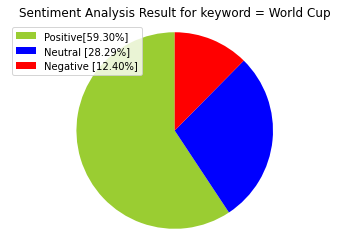

In [15]:
# Creating PieCart
labels = ['Positive['+str(positive)+'%]','Neutral ['+str(neutral)+'%]', 'Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue', 'red']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword = "+keyword+"")
plt.axis('equal')
plt.show()

Additionally, we can identify certain terms that are most commonly associated with our
topic of interest, which, in this case, is World Cup. This can be done with the help of a word
cloud. To create a worcloud, firstly let’s define a function below, so I can use wordcloud again
for all tweets, positive tweets, negative tweets etc.


Word Cloud Saved Successfully


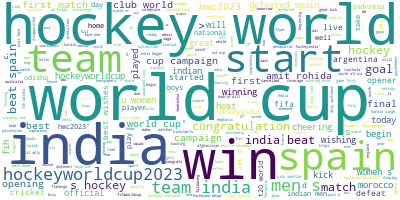

In [16]:
# Function to Create Wordcloud

def create_wordcloud(text):
  # mask = np.array(Image.open("cloud.png"))
  stopwords = set(STOPWORDS)
  wc = WordCloud(background_color="white",
                 max_words = 3000,
                 stopwords=stopwords,
                 repeat=True)
  wc.generate(str(text))
  wc.to_file("wc.png")
  print("Word Cloud Saved Successfully")
  path="wc.png"
  display(Image.open(path))

# Creating wordcloud for all tweets
create_wordcloud(tw_list["text"].values)

Word Cloud Saved Successfully


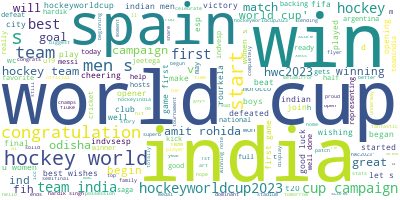

In [17]:
# Creating wordcloud for positive sentiment
create_wordcloud(tw_list_postive['text'].values)

Word Cloud Saved Successfully


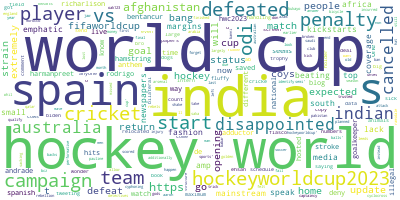

In [18]:
# Creating wordcloud for negative sentiment
create_wordcloud(tw_list_negative['text'].values)

Applying count vectorizer provides the capability to preprocess our text data prior to generating the vector representation making it a highly flexible feature representation module for
text. After count vectorizer, it is possible to analyze the words with two or three or whatever I
6
want.
Applying stemmer is also provides the root of words. So I can eliminate words that come
from the same root, such as ; connect, connection, connected, connections, connects comes from
“connect”. Applying the stemmer function, all words can be considered as same


In [19]:
# Calculating tweet's length and word count
tw_list['text_len'] = tw_list['text'].astype(str).apply(len)
tw_list['text_word_count'] = tw_list['text'].apply(lambda x: len(str(x).split()))
round(pd.DataFrame(tw_list.groupby('sentiment').text_len.mean()), 2)

,text_len
sentiment,
negative,97.19
neutral,93.12
positive,106.35


In [20]:
round(pd.DataFrame(tw_list.groupby('sentiment').text_word_count.mean()), 2)

,text_word_count
sentiment,
negative,16.50
neutral,15.97
positive,18.26


In [21]:

# Removing punctuation
def remove_punct(text):
  text = ''.join([char for char in text if char not in string.punctuation])
  text = re.sub('[0-9]+', '', text)
  return text

tw_list['punct'] = tw_list['text'].apply(lambda x: remove_punct(x))

# Applying tokenization
def tokenization(text):
  text = re.split('\W+', text)
  return text

tw_list['tokenized'] = tw_list['punct'].apply(lambda x: tokenization(x.lower()))

# Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

tw_list['nonstop'] = tw_list['tokenized'].apply(lambda x: remove_stopwords(x))

# Applying stemmer
ps = nltk.PorterStemmer()

def stemming(text):
  text = [ps.stem(word) for word in text]
  return text

tw_list['stemmed'] = tw_list['nonstop'].apply(lambda x: stemming(x))

# Cleaning Text
def clean_text(text):
  text_lc = ''.join([word.lower() for word in text if word not in string.punctuation]) # remove punctuation
  text_rc = re.sub('[0-9]+', '', text_lc)
  tokens = re.split('\W+', text_rc) # tokenization
  text = [ps.stem(word) for word in tokens if word not in stopword]
  # remove stopword and stemming
  return text

# tw_list['cleaned_text'] = tw_list['stemmed'].apply(lambda x: clean_text(x))
tw_list.head()

,Tweet,text,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count,punct,tokenized,nonstop,stemmed
0,"RT @DAZNFootball: ""He asked me to prepare him ...",he asked me to prepare him for his last worl...,0.000,0.066667,neutral,0.0,1.000,0.000,0.0000,97,18,he asked me to prepare him for his last worl...,"[, he, asked, me, to, prepare, him, for, his, ...","[, asked, prepare, last, world, cup, watch, ma...","[, ask, prepar, last, world, cup, watch, marad..."
1,RT @imVkohli: My best wishes to our Indian men...,my best wishes to our indian men s hockey tea...,0.700,0.466667,positive,0.0,0.529,0.471,0.9325,125,25,my best wishes to our indian men s hockey tea...,"[, my, best, wishes, to, our, indian, men, s, ...","[, best, wishes, indian, men, hockey, team, wo...","[, best, wish, indian, men, hockey, team, worl..."
2,India beat Spain 2-0 in their first match of t...,india beat spain 2 0 in their first match of t...,0.250,0.333333,neutral,0.0,1.000,0.000,0.0000,89,15,india beat spain in their first match of the...,"[india, beat, spain, in, their, first, match, ...","[india, beat, spain, first, match, hockey, wor...","[india, beat, spain, first, match, hockey, wor..."
3,"RT @TheHockeyIndia: First game, first win. ✅\n...",first game first win team india began the...,0.225,0.366667,positive,0.0,0.798,0.202,0.5859,121,19,first game first win team india began the...,"[, first, game, first, win, team, india, began...","[, first, game, first, win, team, india, began...","[, first, game, first, win, team, india, began..."
4,RT @BarcaUniversal: Walid Regragui (Morocco co...,walid regragui morocco coach luis enrique...,1.000,0.300000,positive,0.0,0.742,0.258,0.7650,121,22,walid regragui morocco coach luis enrique...,"[, walid, regragui, morocco, coach, luis, enri...","[, walid, regragui, morocco, coach, luis, enri...","[, walid, regragui, morocco, coach, lui, enriq..."


 If
you have a look at our data frame, you can see new features such as punct, tokenized, nonstop,
stemmed.


In [22]:
# Apply Countvectorizer
countVectorizer = CountVectorizer(analyzer=clean_text)
countVector = countVectorizer.fit_transform(tw_list['text'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))
# print(countVectorizer.get_feature_names())

count_vect_df = pd.DataFrame(countVector.toarray(),
                             columns = countVectorizer.get_feature_names())
count_vect_df.head(10)

258 Number of reviews has 854 words


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,,aaron,ab,abboud,abil,abo,absolut,ac,access,achiev,...,wow,write,wydad,x,xess,year,yess,young,yr,zeitgeist
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0, ascending=False).head(20)
countdf[1:11]

,0
world,219
cup,217
india,118
hockey,114
spain,74
win,65
team,56
hockeyworldcup,51
start,45
first,36


Building n gram model helps us to predict most probably word that might follow this
sequence. I create a function then built n2 bigram, n3 trigram etc.


In [24]:
# Function to ngram
def get_top_n_gram(corpus, ngram_range, n=None):
  vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

# n2_bigram
n2_bigrams = get_top_n_gram(tw_list['text'], (2,2), 20)
n2_bigrams

[('world cup', 211),
 ('hockey world', 81),
 ('cup 2023', 32),
 ('team india', 20),
 ('win spain', 17),
 ('men hockey', 16),
 ('beat spain', 16),
 ('india beat', 15),
 ('cup campaign', 14),
 ('campaign win', 14),
 ('match hockey', 13),
 ('hockey team', 12),
 ('spain hockey', 12),
 ('club world', 11),
 ('amit rohidas', 11),
 ('spain match', 9),
 ('cup hockeyworldcup2023', 9),
 ('spain opening', 9),
 ('defeated spain', 7),
 ('19 women', 7)]

In [25]:
# n3_trigram
n3_trigrams = get_top_n_gram(tw_list['text'], (3,3), 20)
n3_trigrams

[('hockey world cup', 80),
 ('world cup 2023', 31),
 ('india beat spain', 15),
 ('world cup campaign', 14),
 ('match hockey world', 13),
 ('spain hockey world', 11),
 ('club world cup', 11),
 ('campaign win spain', 10),
 ('beat spain match', 8),
 ('spain match hockey', 8),
 ('world cup hockeyworldcup2023', 8),
 ('cup campaign win', 8),
 ('men hockey team', 7),
 ('men hockey world', 7),
 ('start world cup', 7),
 ('indian men hockey', 6),
 ('amit rohidas hardik', 6),
 ('men world cup', 6),
 ('cup 2023 india', 6),
 ('t20 world cup', 6)]

## **2. Top 10 hash tags and users based on their number of tweets in the data set.**

To count the top 10 users and hashtags, I will get a list of the
value from 2 columns User and Hashtag.  As of Python, a collections module is available that provides a counter that makes
computing a frequency distribution rather trivial. Here, I use a Counter to compute frequency
distributions as ranked lists of terms and make reviewing the results a little easier on the eyes
by emitting a tabular format. The package prettytable provides a convenient way to emit a
fixed-width tabular format that can be easily copied-and-pasted.

In [26]:
users = [tweet.user.screen_name for tweet in fetched_data]
hashtags = [hashtag['text'] for tweet in fetched_data for hashtag in tweet.entities['hashtags'] ]

from prettytable import PrettyTable
from collections import Counter
for label, data in (('Users', users), ("Hashtag", hashtags)):
  pt = PrettyTable(field_names=[label, "Count"])
  c = Counter(data)
  [pt.add_row(kv) for kv in c.most_common()[:10]]
  pt.align[label], pt.align["COunt"] = 'l', 'r' # Set column alignment
  print(pt)

+-----------------+-------+
| Users           | Count |
+-----------------+-------+
| AKSHAYAU11      |   6   |
| Lord7_RMA       |   4   |
| HetalShekhawat3 |   4   |
| OmPrakashHota06 |   3   |
| adnath7         |   3   |
| Nibedita1425    |   3   |
| Anmoldeep57     |   3   |
| ARUNKUM58229321 |   2   |
| RaajakumaraAppu |   2   |
| afkeno03        |   2   |
+-----------------+-------+
+--------------------+-------+
| Hashtag            | Count |
+--------------------+-------+
| HockeyIndia        |   63  |
| HockeyWorldCup2023 |   47  |
| HWC2023            |   27  |
| HockeyWorldCup     |   20  |
| INDvsESP           |   10  |
| TeamIndia          |   6   |
| FIFAWorldCup       |   4   |
| MetaMirror         |   4   |
| Hockey             |   3   |
| INDvESP            |   3   |
+--------------------+-------+


## **3. Get the followers of a given twitter user from the acquired data set.**

Twitter API also provide function api.followers to retrieve followers of given user. I only need
to pass the user name or user id with limit of follower I want to get, e.g I put the name
mesiihiluf and the limit is set to 10. Then I get a returned results in JSON format, next
I extract some information from the JSON and convert to a DataFrame as below.

In [27]:
followers = api.followers('mesiihiluf', count = 10)
columns = ['Id', 'Name', 'Screen_name', 'Location', 'Description', 'url']
data = []
for follower in followers:
    data.append([follower.id, follower.name, follower.screen_name, follower.location, follower.description, follower.url])

df = pd.DataFrame(data, columns=columns)
# pd.DataFrame(public_tweets)
df

,Id,Name,Screen_name,Location,Description,url
0,1613488027128438785,Wedikeshi Araya,ArayaWedikeshi,,,None
1,906857239121743872,yared gebreegziabher,yaredmekelle1,Ethiopia,My name is yared i am two degree holder i am ...,None
2,1454438875812843522,Usman Ghazi,UsmanGh02545294,KPK,Usman Ghazi,None
3,1605752195860815874,Mark frank Andrew,MarkfrankAndre1,,,None
4,1613784772475555840,hiwan tigray,hiwanhiw,,,None
5,1613467140539011073,mulugeta tetemke,mulugetatetemk1,,,None
6,1613292007887196167,Danait Kahssay,danait_kahssay2,,❤️💛 Broken Tigrigna speaking Tigrawyti Advocat...,None
7,1078395334336774145,Korikilburn,korikilburn,Canada,Owner of CHS Compassionate homestay. Mother of...,None
8,1613327052584914947,Omega TV,OmegaTV100,"Melbourne, Victoria",,None
9,1424139934529724419,Rewina Tigray,asayasmera,Ethiopia,I hope one day everything we be ok.,None


## **4. Obtain the tweets of the user**

By calling api.user timeline, I can quickly get the tweets of a givent user with the user name
(or user id) and the tweets limit.

In [28]:
# The Twitter user who we want to get tweets from
id = 138372303
# Number of tweets to pull
tweetCount = 10

# Calling the user_timeline function with our parameters
results = api.user_timeline(id = id, count = tweetCount)

# foreach through all tweets pulled
for tweet in results:
  print('--------------------------------')
  print(tweet.created_at)
  print(tweet.text)

--------------------------------
2023-01-13 13:00:00
The extraordinary story behind the @England v @selecaoportugal penalties in 2006 😳 

Ricardo is a mentality monster! 🤯
--------------------------------
2023-01-13 12:05:23
Can we get a rating on Musiala’s shooting form? @NBA 🏀
--------------------------------
2023-01-13 12:00:31
Ice cold from the line 🏀❄️

@JamalMusiala | #FIFAWorldCup https://t.co/wdDWyoBkYP
--------------------------------
2023-01-13 11:48:19
The path to #ClubWC glory! 🏆 🤩
--------------------------------
2023-01-13 10:22:00
Discover the path to #ClubWC glory in Morocco LIVE on FIFA+ at 12pm CET 🏆 

🇪🇸 🇧🇷 🇸🇦 🇺🇸 🇲🇦 🇪🇬 🇳🇿
--------------------------------
2023-01-12 21:55:06
Get your popcorn ready 🍿

The Spanish Super Cup Final will be an El Clásico 🇪🇸 https://t.co/qMdZfYQSOs
--------------------------------
2023-01-12 20:39:28
Fresh threads @joaofelix70 🔵⚪️ https://t.co/u1jRyNFctP
--------------------------------
2023-01-12 19:08:12
🇵🇹 Portuguese star @joaofelix70 is